# <span style="color:purple">Esri Denver Regional Webinar - ArcGIS API for Python</span>


## Demo: Automate your administration of your GIS

### We will go over a few workflows to show how the ArcGIS API can help administrators of Web GIS.

#### How to connect to your GIS. Let's import a few modules at the same time. We are importing getpass to provide the GIS object with a password in a safe manner.

In [ ]:
from arcgis.gis import GIS
gis = GIS('https://<your organization>.maps.arcgis.com', 'username', 'password')


In [1]:
from arcgis.gis import *
import getpass
from IPython.display import display
from datetime import date
import csv 
import json
import os
today = date.today()


password = getpass.getpass("Enter password: ")
gis = GIS('https://esridenver.maps.arcgis.com', 'pgamberg@EsriDenver', password)
print("Connected to: {}\nConnected as: {}".format(gis.properties.urlKey + "." + gis.properties.customBaseUrl,
                                                 gis.users.me.username))

Enter password: ········
Connected to: esridenver.maps.arcgis.com
Connected as: pgamberg@EsriDenver


## We are now connected to our GIS and can begin working with it

### And the API has built in help

In [ ]:
gis.users.


# Working with content
### As content publishers, you may be required to keep certain web layers up to date. As new data arrives, you may have to append new features, update existing features etc. 

## Update published content for an open data site
### To publish a csv, we first add the csv file as content in our GIS, then call publish() method on the item to create a web layer. Often times, your shape files or service definitions may not contain the metadata you want to show on the portal item. This sample demonstrates how you can update those properties after publishing a web layer.

In [7]:
csv_file = 'data/pending_business_licenses.csv'
try:
    pending_business_licenses = gis.content.search('Pending Business License', item_type='CSV')
    if len(pending_business_licenses) != 0:
        print()
        item_ids = []
        for item in pending_business_licenses:
            item_ids.append(item.itemid)
    for item_id in item_ids:
        try:
            item = gis.content.get(itemid=item_id)
            item.delete()
        except Exception as add_ex:
            print(add_ex)
except Exception as add_ex:
    print(add_ex)

    
    
    
csv_item = gis.content.add(
    {'title':"Pending Business Licenses " + str(today)}, 
    csv_file, 
    folder='python webinar')
print('Pending Business Licenses CSV file has been updated.')
csv_lyr = csv_item.publish(None, {"Address":"ESTABLISHMENT_ADDRESS"}, overwrite=True)
csv_lyr.share(everyone=True, groups="6e5130c325a34b6d907eba4b95a7b950")
print('Pending Business Licenses hosted feature service has been republished with updated CSV data.')



Pending Business Licenses CSV file has been updated.
Pending Business Licenses hosted feature service has been republished with updated CSV data.


In [15]:
display(csv_lyr)


<Item title:"Pending Business Licenses 2019-08-06" type:Feature Layer Collection owner:pgamberg@EsriDenver>

### Update the layer item's metadata

<Item title:"City of Denver Pending Business Licenses" type:Feature Layer Collection owner:pgamberg@EsriDenver>
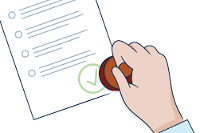

In [16]:
thumbnail_path = ".//data//businessLicense.PNG"
item_properties = {"snippet":"""This dataset was collected from the City of Denver open data portal. Source URL: <a href="https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-pending-business-licenses">https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-pending-business-licenses</a>""", 
                   "title":"City of Denver Pending Business Licenses", 
                   "tags":"opendata"}
csv_lyr.update(item_properties, thumbnail=thumbnail_path)
display(csv_lyr)


## Publish all the shapefiles files in a folder
### The sample below lists all the service definition (.sd) files in a data directory and publishes them as web layers. To publish a service definition file, we first add the .sd file to the Portal, and then call the publish() method:

In [26]:
data_dir = "data/shapefiles/"

#Get list of all files
file_list = os.listdir(data_dir)
#Filter and get only .shp files
shp_file_list = [x for x in file_list if x.endswith(".zip")]
print("Number of compressed shapefiles files found: " + str(len(shp_file_list)))

# create a new folder
new_folder_details = gis.content.create_folder('new folder')

# Loop through each file and publish it as a service
for current_shp_file in shp_file_list:
    item = gis.content.add({}, data_dir + current_shp_file)
    new_item = item.publish()
    print('')
    print(current_shp_file, "published as:")
    display(new_item)
    new_item.move(new_folder_details)  # Here you could either pass name of the folder or the dictionary
    item.delete()   

Number of compressed shapefiles files found: 3

power_pedestals_2012.zip published as:


<Item title:"power_pedestals_2012" type:Feature Layer Collection owner:pgamberg@EsriDenver>


abandoned_trolley_tracks.zip published as:


<Item title:"abandoned_trolley_tracks" type:Feature Layer Collection owner:pgamberg@EsriDenver>


downtown_denver_historic_district.zip published as:


<Item title:"downtown_denver_historic_district" type:Feature Layer Collection owner:pgamberg@EsriDenver>

# Working with users

## Create and manage users
### There is alot of user information we can gather and use to help us manage the users of our web GIS

In [17]:
new_user = gis.users.create(
    username = 'pete_student',
    firstname = 'Peter',
    lastname = 'Gamberg',
    password = 'student123!',
    email = 'pgamberg@gmail.com',
)
display(new_user)

<User username:pete_student>

In [18]:
items = new_user.level
display(items)

'2'

In [12]:
###############
# Create Groups
def create_groups():
    print("CREATING GROUPS")
    # open csv file of groups as a dictionary. loop through dictionary to create groups
    with open(".//project_setup//groups.csv", 'r') as groups_csv:
        groups = csv.DictReader(groups_csv)
        for group in groups:
            try:
                print(" Creating group: ", group['title'], end="  ##  ")
                result = gis.groups.create_from_dict(group)
                if result:
                    print("success")
            except Exception as create_ex:
                print("Error... ", str(create_ex))

##############
# Create Users                
def create_users():
    # open csv file of users as a dictionary. loop through and create users
    with open(".//project_setup//users.csv", 'r') as users_csv:
        users = csv.DictReader(users_csv)
        for user in users:
            try:
                print("Creating user: ", user['username'], end=" ## ")
                
                result = gis.users.create(username=user['username'],
                                          password=user['password'],
                                          firstname=user['Firstname'],
                                          lastname=user['Lastname'],
                                          email=user['email'],
                                          role=user['role'],
                                         )
                
                if result:
                    print("success  ##")

                    print("\t Adding to groups: ", end=" # ")
                    groups = user['groups']
                    group_list = groups.split(",")

                    # Search for the group
                    for g in group_list:
                        group_search = gis.groups.search(g)
                        if len(group_search) > 0:
                            try:
                                group = group_search[0]
                                groups_result = group.add_users([user['username']])
                                if len(groups_result['notAdded']) == 0:
                                    print(g, end =" # ")

                            except Exception as groups_ex:
                                print("\n \t Cannot add user to group ", g, str(groups_ex))
                    print("\n")

            except Exception as add_ex:
                print("Cannot create user: " + user['username'])
                print(str(add_ex))              
########################################################################

In [19]:
create_groups()
create_users()

CREATING GROUPS
 Creating group:  Basemaps  ##  success
 Creating group:  Central Services  ##  success
 Creating group:  Compliance  ##  success
 Creating group:  Customer Service, Finance, Billing and Accounting  ##  success
 Creating group:  Demographic Content  ##  success
Creating user:  JohnsonStewart ## success  ##
	 Adding to groups:  # Basemaps #  Central Services # 

Creating user:  WilliamsSanchez ## success  ##
	 Adding to groups:  # Basemaps #  Customer Service # 

Creating user:  DavisReed ## success  ##
	 Adding to groups:  # Basemaps #  Demographic Content # 

Creating user:  WilsonMorgan ## success  ##
	 Adding to groups:  # Basemaps #  Compliance #  Demographic Content # 



### When it is time to clean up the organization you can remove a user by deleting all thier content, folders, owned groups, and revoking thier licensed apps/software

#### Create a list of users to remove from your portal

In [20]:
users = []
user_list = gis.users.search("webinar")
print(len(user_list)," users returned")
n = len(user_list)
for u in range(n):
    users.append(user_list[u])
for u in users:
    print(u)

2  users returned
<User username:webinar_A>
<User username:webinar_B>


#### delete all the users in the above defined list

In [21]:
def delete(users):
    for user in users:
        try:
            display(user)

            # Accessing users folders, delete the content
            print("Searching for user folders...")
            folders = user.folders
            print("Deleting folders and thier content...")
            for folder in folders:
                folder_items = user.items(folder=folder['title'])
                for item in folder_items:
                    item.protect(enable=False)
                    item.delete()
                gis.content.delete_folder(folder['title'],owner=user)
            print("...Done")
            
            
            
            # Delete content within root folder
            print("Searching users root folder...")
            items = (user.items())
            print("Deleting content from root folder...")
            for item in items:
                item.protect(enable=False)
                item.delete()
            print("...Done")
            
            
            
            
            
            # Delete user groups
            try:
                groups = user.groups
                print("Searching for user owned groups...")
                for group in groups:
                    #print(group.protected)
                    if group.owner == user.username:
                        if group.protected==True:
                            group.protected=False
                        #print(group.protected)
                        #print("")
                        group.delete()

                    else:pass
                print("Deleting user owned groups...")

            except Exception as add_ex:
                print(add_ex)

            print("...Done")
            
            
            
            # Revoke licenses
            licenses = gis.admin.license.all()
            print("Revoking licenses...")
            for l in licenses:
                string = str(l) 
                n = string.find('License')
                license_name = string[1:(n-1)]
                print("    ",license_name)
                a = gis.admin.license.get(license_name)
                try:
                    a.revoke(user.username,'*')
                except:
                    pass
            print("...Done")
                
            
            
            
            
            
            # delete user from portal
            print("Deleting user...")    
            try:
                user.delete()
                print(user.username," deleted")
            except:
                user.disable()
                print(user.username, " disabled")
                
                
                
                
        except Exception as add_ex:
            print("exception ")
            print(add_ex)            
        print("")
        print("")
    
    

In [22]:
delete(users)

<User username:webinar_A>

Searching for user folders...
Deleting folders and thier content...
...Done
Searching users root folder...
Deleting content from root folder...
...Done
Searching for user owned groups...
Deleting user owned groups...
...Done
Revoking licenses...
     Survey123 for ArcGIS
     Insights for ArcGIS
     Redistricting Online
     ArcGIS Pro
     SafeGraph Places for ArcGIS June-2019 (v2019-05-30)


not licensed by user


     Drone2Map for ArcGIS
     GeoPlanner for ArcGIS
     AppStudio for ArcGIS
     Workforce for ArcGIS
     ArcGIS Community Analyst
     Navigator for ArcGIS
     Admin Tools for ArcGIS℠ Online


not licensed by user


     Collector for ArcGIS
     ArcGIS Business Analyst Web and Mobile Apps
     CityEngine
...Done
Deleting user...
webinar_A  deleted




<User username:webinar_B>

Searching for user folders...
Deleting folders and thier content...
...Done
Searching users root folder...
Deleting content from root folder...
...Done
Searching for user owned groups...
Deleting user owned groups...
...Done
Revoking licenses...
     Survey123 for ArcGIS
     Insights for ArcGIS
     Redistricting Online
     ArcGIS Pro
     SafeGraph Places for ArcGIS June-2019 (v2019-05-30)


not licensed by user


     Drone2Map for ArcGIS
     GeoPlanner for ArcGIS
     AppStudio for ArcGIS
     Workforce for ArcGIS
     ArcGIS Community Analyst
     Navigator for ArcGIS
     Admin Tools for ArcGIS℠ Online


not licensed by user


     Collector for ArcGIS
     ArcGIS Business Analyst Web and Mobile Apps
     CityEngine
...Done
Deleting user...
webinar_B  deleted




# Administrative question asking of your web GIS

#### Who has never signed in? Who has not signed in within the past year?

In [23]:
# make a list of all users
user_list = gis.users.search(max_users=200)

# create variables to compare last login times, all in unix time
now = datetime.utcnow().timestamp()
one_year_ago = (now - 31536000) # 31536000 is a year in unix time

# create lists to populate with users who meet criteria
no_login = []
non_user = []
for user in user_list:
    s = str(user.lastLogin)
    t = int(s)
    if user.lastLogin == -1:
        no_login.append(user)
    elif t/1000 < one_year_ago:
        non_user.append(user)
    else:pass

print('Users who have never logged in:')
print("{:<25}\t{:<25}\t{:25}".format("Username", "Last Login", "Email"))
print("{:*<25}\t{:*<25}\t{:*<25}".format("", "", ""))
for user in no_login:
    print("{:<25}\t{}\t{}".format(user.username,
                            datetime.fromtimestamp(user.lastLogin/1000).ctime(),user.email))
print("")  
print("{:*<50}".format(""))
print("{:*<50}".format(""))
print("{:*<50}".format(""))
print("")  
print('Users who have not logged in within the past year:')
print("{:<25}\t{:<25}\t{:25}".format("Username", "Last Login", "Email"))
print("{:*<25}\t{:*<25}\t{:*<25}".format("", "", ""))
for user in non_user:
    print("{:<25}\t{}\t{}".format(user.username,
                            datetime.fromtimestamp(user.lastLogin/1000).ctime(),user.email))


Users who have never logged in:
Username                 	Last Login               	Email                    
*************************	*************************	*************************
DavisReed                	Wed Dec 31 16:59:59 1969	davis.reed@company.com
dvaillancourt_esridenver1	Wed Dec 31 16:59:59 1969	dvaillancourt@esri.com
JohnsonStewart           	Wed Dec 31 16:59:59 1969	johnson.stewart@company.com
pete_student             	Wed Dec 31 16:59:59 1969	pgamberg@gmail.com
WilliamsSanchez          	Wed Dec 31 16:59:59 1969	williams.sanchez@company.com
WilsonMorgan             	Wed Dec 31 16:59:59 1969	wilson.morgan@company.com

**************************************************
**************************************************
**************************************************

Users who have not logged in within the past year:
Username                 	Last Login               	Email                    
*************************	*************************	**********************

#### Notify users who have not signed in recently that thier account will be deleted within the next 30 days

In [24]:
me = gis.users.search('pgamberg@EsriDenver')

# send and email to users who have not used the organization in the past year
# use me or non_user as list variable
try:
    gis.users.send_notification(non_user, 
                        "You have not signed in lately?", 
                        "You have not signed into Esri Denver within the past year. Your account is under evaluation and being considered for allocation elsewhere in the organization. If this is an account you need for your work, please reach out to Pete Gamberg.",
                        type = "email",
                       )
    print('notifications sent')
    

except Exception as create_ex:
    print("Error... ", str(create_ex))         


notifications sent


### How much content is in my web GIS?

In [43]:
all_content = gis.content.search(query="*", max_items = 1000000000)
print(len(all_content), " items within ", gis.url)

2240  items within  https://esridenver.maps.arcgis.com


### How many credits do I have remaining?

In [53]:
gis.properties.availableCredits

146751.5

### What layers are in my web maps?

In [54]:
wmaps = gis.content.search("*", item_type="Web Map", max_items = 10000, outside_org=False)

for wbmap in wmaps:
    print("{}".format(wbmap.title))
    print("{:*<90}".format(""))
    raw_data = wbmap.get_data()
    lyrs = raw_data['operationalLayers']
    for lyr in lyrs:
        try:
            if 'itemId' in lyr.keys():
                print("\t{:<50}{}".format(lyr['title'][:45], lyr['itemId']))
            else:
                print("\t{:<50}{}".format(lyr['title'][:45], lyr['id']))
        except:
            pass
    print("\n")






Fire Hydrant Inspection
******************************************************************************************
	Fire Hydrants                                     b923257e2ec24ee98c9270ab2597b2ba


Naloxone Deployments  Dashboard
******************************************************************************************
	Naloxone Deployment Reporter_dashboard            6a09a7b74de449e4a25a66bb961678b4


Modern Antique Take by JP2
******************************************************************************************


NOLA_PublicHealthClinics
******************************************************************************************
	PublicHealthClinics                               984752f2518e4a968e306b01d26e016a


Restaurant Inspection Results
******************************************************************************************
	RestaurantInspections_Public                      9794c9f449e8410db3feca6a1400f027


Restaurant Inspections Dashboard
****************************

	Pre-Incident Plans                                67ffa36c6cda4a88b4dce8ce2b10a98e
	Fire Hose Lines                                   67ffa36c6cda4a88b4dce8ce2b10a98e
	Fire Suppression Systems                          67ffa36c6cda4a88b4dce8ce2b10a98e
	Hazardous Materials                               67ffa36c6cda4a88b4dce8ce2b10a98e
	Key Boxes                                         67ffa36c6cda4a88b4dce8ce2b10a98e
	Occupancies                                       67ffa36c6cda4a88b4dce8ce2b10a98e
	Alarm Control Panels                              67ffa36c6cda4a88b4dce8ce2b10a98e
	Utility Shutoffs                                  67ffa36c6cda4a88b4dce8ce2b10a98e


Hurricane Tracks Arcade Test
******************************************************************************************
	Historic Hurricanes                               cc90955797ac4343b6b90eb34569a909


Drone Project Inventory Map
******************************************************************************************
	

	Trees Planted on Sept. 21, 2017 - Condition       survey123_5e10b178445f449f882a1515770e360e_3028_734_855
	Trees Planted on Aug. 30, 2016- Condition         survey123_5e10b178445f449f882a1515770e360e_3028_734
	CollectorCorners                                  bc8a1dca0cf64895a0a19b07f5361493
	Esri Denver Property Boundaries                   0776fe2bcbc44638a7f25a4eb05a22e1
	Trees - Species                                   48d74793e6504a0282c83b1d06ac6a2f
	Tree-Condition                                    3dee3cf63b0548c792a39a6b22c883da


Burgers and  Beer Site Map
******************************************************************************************
	2017_03_24_LA_Coliseum_Orthomosaic                1b36d8b7bbcb4803b59c1fe3c49b993a
	Community Event Areas                             64ad2a3fd35341ba938d17d856212f11
	Community Event Routes                            64ad2a3fd35341ba938d17d856212f11
	Community Event Assets                            64ad2a3fd35341ba938d17d856212f1

	Workers                                           336ed205a6c04483980f53484770b5e5
	Requests                                          4abefe9ee4a34a3ca840a8fab58039c9


Park Locator
******************************************************************************************
	Parks                                             617dc7a3154b4657b6b602d1d1408b73
	Golf Courses                                      617dc7a3154b4657b6b602d1d1408b73


DPS
******************************************************************************************
	Denver Public Schools                             0fbe2181cc2d439790c5262fd0505d9b


Lowell Traffic Web Map
******************************************************************************************
	Lowell Traffic Points                             3fb9c2a3cace4744b8776e486164b950


Election Results - Elected Office
******************************************************************************************
	Elected Office Results                           

	survey123_dac6eefed3b94d80bea7fd6e482ff987 -      survey123_dac6eefed3b94d80bea7fd6e482ff987_7254


Mosquito Treatments - new web map
******************************************************************************************
	MosquitoTreatments - Treatment Exemption Area     d80d0d56f12a4b2bb6b00e97bbd83ced
	MosquitoTreatments - Adultcide Treatment Area     d80d0d56f12a4b2bb6b00e97bbd83ced
	MosquitoTreatments - Larvicide Sites              d80d0d56f12a4b2bb6b00e97bbd83ced
	MosquitoTreatments - Treatment Exemptions         d80d0d56f12a4b2bb6b00e97bbd83ced


Election Results - Proposal
******************************************************************************************
	Proposal Results                                  8cf19ac8d2ea41898fe8aa5f2ff21587
	Jurisdictions                                     999f172e919f4a1d8c9c47eec09f0c23


Landsat 5, September 10, 1992, Las Vegas
******************************************************************************************
	1992_09_10_Lan

	Travel_from_Esri_Office_(Points)_(30_Minutes)     a1d8260a81404165a662c6e534b85c4b
	Travel_from_Esri_Office_(Points)_(40_Minutes)     a40cfe4926d6461ea7d875160cf6e96e
	Travel_from_Esri_Office_(Points)_(50_Minutes)     e5e5c0e458734cbeaa4f0c91ed338152
	Home_to_New_Home                                  1addf9dd9f914a5b95d0a67c52351bc3
	Esri_Office_to_Home                               e69f4ec3e9d54f91a9eda8890143286f
	Esri_Office_to_New_Home                           55a5880b58364785ba31008e57ae7c22
	Home_Work_Morning                                 959a5756fc3342a484e6ca0171c420ee
	New_Home_to_Work                                  aab612d19fb246d2893975e03edce0a6
	Work_to_Home                                      3a24567db80f49c2a1425100fa323e14
	Work_New_Home_Evening                             2dabec237be34bbb8f61d9b3b9eb8928
	Work                                              mapNotes_4594
	Home                                              mapNotes_4838
	New Home?                    

	Location Tracking                                 bafa44380d67401cad98913e37784192
	Assignments                                       8e72ae520b22415dbc3dcd17c44cc52d
	Workers                                           6aa19d54306d4f139a991571771e9a66


Events Site Map
******************************************************************************************
	2017_03_24_LA_Coliseum_Orthomosaic                1b36d8b7bbcb4803b59c1fe3c49b993a
	Community Event Areas                             64ad2a3fd35341ba938d17d856212f11
	Community Event Routes                            64ad2a3fd35341ba938d17d856212f11
	Community Event Assets                            64ad2a3fd35341ba938d17d856212f11
	Community Event                                   adc2c30fde594fa6b565052b67bfa910


Real-Time Snowplow Map-Copy
******************************************************************************************
	Street Plowed Status                              c4ce18583a624fa0a3135a783f3cf8fb
	Tracks       

	FRSP_Trails                                       bdc91dc34e27444a987918b3bf0f17a4


Esri Maps for Adobe - Manhattan
******************************************************************************************
	2017 USA Electronics Stores Market Opportunit     663de5b5773a48b4b3a53df87dc21394


full 2018
******************************************************************************************
	Gilbert 2018Calls for Service                     11dddaf8599e4914831f6ceebdce6694


Big Island Lava Flow Hazard Zones
******************************************************************************************
	Terrain                                           f76fcd9eab5148e295acd933a28cf6aa
	Lava Flow Hazard Zones                            6c6375d891ea4edea42172afb1df1096
	Highways                                          12f53874b5cc423db0e8acb8eaf032bb
	Volcanoes                                         b225a2f37c294916b5865a0fb2f98b74
	Emergency Shelters                                featCo

	Parks                                             6ee77809d62a46fb9682063a9c2fe229
	Golf Courses                                      6ee77809d62a46fb9682063a9c2fe229


Nested Related Tables Web Map
******************************************************************************************
	Nested_Relationship_FC_Testing                    24f94be5445445409159f96a55500b34


Maps on the Hill Landsat Map
******************************************************************************************
	Multispectral Landsat                             d9b466d6a9e647ce8d1dd5fe12eb434b


Alternative Fuel Stations Map 3
******************************************************************************************
	Travel from Salt Lake City (60 Minutes)           6e6944145b784d54bf024a5115965627
	Alternative Fuel Stations                         Alternative_Fuel_Stations_5323_8818_5425_2988_3249_5763
	Electric Fuel Stations 60 Minutes Salt Lake C     971e5cc2de354bd197279baf26007666
	Salt_Lake_City    

	Road Complaints                                   e023295caae54945b6396d6cb42c2194


Dispatchers
******************************************************************************************
	Assignments                                       db62d4e58f1d4cf9abc7af548dd08a9a
	Workers                                           a500121e083d4b059085d6b913648489


Noxious Weeds
******************************************************************************************
	Park Boundary                                     711963b6e07148e0ae61eddcf1453414
	Known Infestation Areas                           711963b6e07148e0ae61eddcf1453414
	Noxious Weeds                                     b3444267087b4e409fd2764a23701bff


Sample Map
******************************************************************************************
	USA Wildfire Activity                             4d63f7de557c4a69bab44c376c0d3565


Denver RO  Drone2Map with GCPs
***************************************************************

	Hurricane Evacuation Routes                       8dd859379d904396b776f5428afc8f10


Denver Parks Map
******************************************************************************************
	Denver_parks                                      643d2399f91d4ac48ee9b3d045eb0df0


US Schools Map _vector tiles
******************************************************************************************
	PublicSchools_vectortiles                         3407c75684614dab9e98748aa3c1b436


My Elected Representative
******************************************************************************************
	President of the United States                    176b5f64b400439884159ae929b45922
	United States Senate                              176b5f64b400439884159ae929b45922
	United States House of Representatives            176b5f64b400439884159ae929b45922
	State Treasurer                                   176b5f64b400439884159ae929b45922
	State Attorney General                            176b5f64b4

	Blight Complaints                                 605b643b848844fbadb546e1964405cf


UA Waste Management Map
******************************************************************************************
	SustainabilityDynamic_RecycleBins - Recycling     24b32288ba864936ba5440450c5b2b47
	SustainabilityDynamic_TrashCans - Trash Cans      0d3be159260646d08b75d316ed57be2a


Denver RO Tree Map
******************************************************************************************
	DenverRO_2D_Orthomosaic                           DenverRO_2D_Orthomosaic_6751
	OfficeTreeMap_WFL1                                528869072b7944dd9c2d0905264121b5


Fire Hydrant Survey Map - MB
******************************************************************************************
	Fire Hydrants - Inspection Due                    Water_Fire_Hydrant_Survey_4159_6108_1494
	Fire Hydrants - Inspected                         Water_Fire_Hydrant_Survey_4159_6108


Vision Zero Dashboard
******************************

### Where is a layer being used? Notify users of a layer about upcoming changes

In [55]:
id_of_interest = '6001f14a10fb4b1b817b51b06271f9b4'
# dceeac214d7a49c0a7efed1d3a0bd418
# 6df12deee1874485b110d2ed1342256c
# 1b36d8b7bbcb4803b59c1fe3c49b993a
# 6aaab8f9d9ee480a9ece9ff46e1b141b
# 0776fe2bcbc44638a7f25a4eb05a22e1
lyr_itm = gis.content.get(id_of_interest)
lyr = lyr_itm.layers[0]
layer_name = lyr.properties.name
layer_url = lyr.url
print("{} is in the following Web Maps:".format(lyr.properties.name))
print("{:-<50}".format(""))
lyr = None
notify_list = []
for wm in wmaps:
     raw_data = wm.get_data()
     lyrs = raw_data['operationalLayers']
     for lyr in lyrs:
        if 'itemId' in lyr.keys() and lyr['itemId'] == id_of_interest:
            print("\t" + wm.title)
            notify_list.append((wm.owner,wm.title))  
print("")
print("")
print("Notifying map owners about layer change")
print("")
for user in notify_list:
    try:
        u = gis.users.search(user[0])
        if len(u) > 0:
            try:
                gis.users.send_notification(u, 
                        "A change is coming to a web layer you use!",
                        "There is a change coming to the web layer " + layer_name + ". This layer is located at: "  + layer_url + ". This may effect the configuration within the web map you own titled '" + user[1] + "'.",
                        type = "email",
                       )
                print('notification sent to ' + u[0].fullName)
    
            except Exception as create_ex:
                print("Error... ", str(create_ex))      
            
    except Exception as create_ex:
        print("Error... ", str(create_ex))

Denver_schools is in the following Web Maps:
--------------------------------------------------
	Tobacco retail analysis
	Collect new locations
	Denver schools and parks


Notifying map owners about layer change

notification sent to Pete Gamberg
notification sent to Pete Gamberg
notification sent to Pete Gamberg


### Who is consuming the most credits?

In [56]:
user_mgr = arcgis.gis.UserManager(gis)
storage = user_mgr.search(role='org_publisher')
#storage = user_mgr.search('*')

most_storage = []
for user in storage:
    megabyte = round(user.storageUsage/1000000)
    credit = round(megabyte/2.4)
    most_storage.append([user.fullName,megabyte,credit])
most_storage.sort(key=lambda tup: tup[1], reverse=True)
most_storage[:10]




[['jen mccall', 340, 142],
 ['Alicia Henry', 1, 0],
 ['Autumn Martinez', 1, 0],
 ['Wendy Downing', 1, 0],
 ['Will Turner', 1, 0],
 ['AA Student', 0, 0],
 ['A Student', 0, 0],
 ['Bryn Brum', 0, 0],
 ['BB Student', 0, 0],
 ['Beau Legeer', 0, 0]]

## END

## Clean up code. Delete user content, users, and groups

We're going to run a clean up script(clean.py) in my local IDE(PyCharm) removing everything except the admin account and some groups. 



In [57]:
def clean():
    # loop through and create users
    with open(".//project_setup//users.csv", 'r') as users_csv:
        users = csv.DictReader(users_csv)
        for user in users:
            try:
                n = gis.users.get(user['username'])
                i = (n.items())
                for c in i:
                    c.delete()
                n.delete()
                print(str(n.username) + ' and their content has been deleted sucessfully')
                

            except Exception as add_ex:
                print("exception " + user['username'])
                print(str(add_ex))
                
    with open(".//project_setup//groups.csv", 'r') as groups_csv:
        groups = csv.DictReader(groups_csv)
        for group in groups:
            try:
                result = gis.groups.search(group['title'])
                if result:
                    t = arcgis.gis.Group.delete(result[0])
                    print(group['title'] + ' sucessfully deleted')
            except Exception as create_ex:
                print("Error... ", str(create_ex))            
    
    
                
clean()
student = gis.users.get('pete_student')
try:
    student.delete()
    print(student,' successfully deleted')
except:
    print('user not deleted')
    
    
    
    
    
users = []
user = gis.users.get("pgamberg@EsriDenver")
folders = user.folders
# here we isolate the folder to delete based on the folder name, copied from the previous block of code.
f=[]
for folder in folders:
    if folder['title'] == "new folder":
        f.append(folder)       
#here we delete the content
for folder in f:
    folder_items = user.items(folder=folder['title'])
    for item in folder_items:
        related_items = item.related_items("Service2Service")
        if len(related_items) > 0:
            for i in related_items:
                i.protect(enable=False)
                i.delete()
            remaining_items = user.items(folder=folder['title'])
            for remaining_item in remaining_items:
                if remaining_item in folder_items:
                    folder_items.remove(remaining_item)
                remaining_item.protect(enable=False)
                remaining_item.delete()
        else:
            item.protect(enable=False)
            item.delete()
    gis.content.delete_folder(folder['title'],owner=user)



JohnsonStewart and their content has been deleted sucessfully
WilliamsSanchez and their content has been deleted sucessfully
DavisReed and their content has been deleted sucessfully
WilsonMorgan and their content has been deleted sucessfully
Basemaps sucessfully deleted
Central Services sucessfully deleted
Compliance sucessfully deleted
Customer Service, Finance, Billing and Accounting sucessfully deleted
Demographic Content sucessfully deleted
<User username:pete_student>  successfully deleted
